Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/08 12:59:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/08 12:59:24 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [13]:


from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import SparkSession
from operator import add
from pyspark.sql.functions import *
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.11:7077") \
        .appName("test")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",1)\
        .config("spark.cores.max",4)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()
        #.config("spark.executor.memory", "1gb")\  ##?????????
        #.config("spark.dynamicAllocation.minExecutors", 1)
        
spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

reddit = spark_context.textFile("hdfs://192.168.2.11:9000/user/ubuntu/redditcomments/RC_2005-12").cache()
reddit_df = spark_session.read.json(reddit)


In [5]:
reddit_df = spark_session.read.json(reddit)
reddit_df.printSchema()

22/03/11 09:31:40 ERROR TaskSchedulerImpl: Lost executor 3 on 192.168.2.11: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/03/11 09:32:54 ERROR TaskSchedulerImpl: Lost executor 18 on 192.168.2.11: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.


root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [ ]:
reddit_df = reddit_df.select("body", "controversiality", "subreddit", "subreddit_id", "created_utc")
reddit_df.show(1)

In [55]:
from pyspark.sql.functions import *
from pyspark.sql.functions import sum

republicanReddits = reddit_df.filter(col("body").contains("and")\
                                     | col("body").contains("trump")\
                                     | col("body").contains("Republican")\
                                     | col("body").contains("republican"))
print(republicanReddits.show())
a = republicanReddits.select(sum("controversiality"))
print(a.show())
controversialRepublicanRatio = republicanReddits.select(sum("controversiality")).first()[0] / republicanReddits.count()


democratReddits = reddit_df.filter(col("body").contains("is")\
                                   | col("body").contains("hillary") \
                                   | col("body").contains("Democrat")\
                                   | col("body").contains("democrat"))
controversialDemocratRatio = reddit_df.select(sum("controversiality")).first()[0] / reddit_df.count()

print(f"Democrats controversial ratio: {controversialDemocratRatio}")
print(f"Republicans controversial ratio: {controversialRepublicanRatio}")

+---------------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+---+--------+---------+------------+-----+--------+----------+------------+---+
|         author|author_flair_css_class|author_flair_text|                body|controversiality|created_utc|distinguished|edited|gilded| id| link_id|parent_id|retrieved_on|score|stickied| subreddit|subreddit_id|ups|
+---------------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+---+--------+---------+------------+-----+--------+----------+------------+---+
|           frjo|                  null|             null|A look at Vietnam...|               0| 1134365188|         null| false|     0|c13|t3_17863| t3_17863|  1473738411|    2|   false|reddit.com|        t5_6|  2|
|        zse7zse|                  null|             null|The site states "...|               0| 1134365725|         null| false|     0|

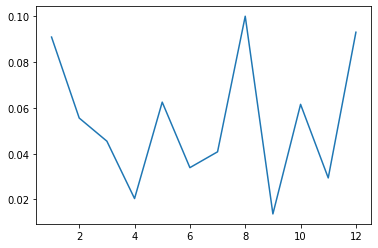

In [56]:
from pyspark.sql import functions as F
from pyspark.sql.types import LongType
import matplotlib.pyplot as plt

democratReddits = democratReddits.withColumn("created_utc", F.to_utc_timestamp(F.from_unixtime(F.col("created_utc").cast(LongType()),'yyyy-MM-dd'),'EST'))
controDemocratOverTime = democratReddits.groupBy("created_utc").agg(avg("controversiality")).orderBy("created_utc")

republicanReddits = democratReddits.withColumn("created_utc", F.to_utc_timestamp(F.from_unixtime(F.col("created_utc").cast(LongType()),'yyyy-MM-dd'),'EST'))
controRepublicanOverTime = democratReddits.groupBy("created_utc").agg(avg("controversiality")).orderBy("created_utc")

v = list(range(1, len(controDemocratOverTime.select("created_utc").collect()) + 1))
plt.plot(v, controDemocratOverTime.select("avg(controversiality)").collect())


plt.show()

In [19]:
# Calculate overall controversiality average
from pyspark.sql.functions import sum
averageControversialityFullSet = democratReddits.select(sum("controversiality")).first()[0] / democratReddits.count()

print(averageControversialityFullSet)

0.046511627906976744


In [5]:

contro_subreddit = reddit_df.select("controversiality", "subreddit_id", "subreddit")

avg_controversial = contro_subreddit.groupBy("subreddit_id").agg(avg("controversiality"), count("subreddit"))
    
avg_controversial_sorted = avg_controversial.orderBy("avg(controversiality)",ascending=False)
print(avg_controversial_sorted.show(10))



+------------+---------------------+----------------+
|subreddit_id|avg(controversiality)|count(subreddit)|
+------------+---------------------+----------------+
|        t5_6| 0.046511627906976744|            1075|
+------------+---------------------+----------------+

None


In [12]:
test = reddit_df.select("controversiality").where(col("controversiality") == 1)
print(avg_controversial_sorted.select("subreddit_id").show(10))

+------------+
|subreddit_id|
+------------+
|        t5_6|
+------------+

None


In [25]:
print(avg_controversial_sorted.show(10))


+------------+---------------------+----------------+
|subreddit_id|avg(controversiality)|count(subreddit)|
+------------+---------------------+----------------+
|        t5_6| 0.046511627906976744|            1075|
+------------+---------------------+----------------+

None


In [12]:
spark_context.stop()